In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz
from scipy import ndimage

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *
# from utilities import mask_boundary_points
# from utilities import get_invariants
# from utilities import get_tensor_functions
# from torchToFoam import writesymmtensor

# standard datatype
dtype = th.double

In [2]:
def time():
    return datetime.datetime.now().strftime("%y-%m-%d_%H-%M")

In [3]:
def trace(tensor):
    return (tensor[:,0,0] + tensor[:,1,1] + tensor[:,2,2])

In [4]:
def filterField(inputData, std, filter_spatial='Gaussian'):
    """
    Filter a field (e.g. predicted b_ij) spatially using a gaussian or median filter
    """
    if len(inputData.shape) == 4:
        outputData = np.zeros(inputData.shape)
        for i1 in range(inputData.shape[0]):
            for i2 in range(inputData.shape[1]):
                if filter_spatial == 'Gaussian':
                    outputData[i1,i2,:,:] = ndimage.gaussian_filter(inputData[i1,i2,:,:], 
                              std, order=0, output=None, mode='nearest', cval=0.0, truncate=10.0)
                elif filter_spatial == 'Median':
                    outputData[i1,i2,:,:] = ndimage.median_filter(inputData[i1,i2,:,:], 
                              size=std, mode='nearest')
    
    else: #TODO: other input shapes
        pass

    return outputData

In [5]:
# set path to models and initialise arrays
# model_path = '../storage/models/kaandorp_data/ph_cdc/20000dp_1000ep_1000bs_2-5e-5lr/model.pt' # this was used for prediction on 2800
model_path = '../storage/models/kaandorp_data/ph_cdc_sd/invariants_corrected/loss_b_unique'

model = th.load(os.sep.join([model_path, 'model.pt']))
mu = th.load(os.sep.join([model_path, 'mu.th']))
std = th.load(os.sep.join([model_path, 'std.th']))
_ = model.eval()  # mandatory, see torch.load doc

In [21]:
# read in tensor data
pred_path = '/home/leonriccius/Desktop/PeriodicHills/Re2800/Re2800_kOmega_150_dd_corr_inv'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/rans_kaandorp/PeriodicHills/Re5600_kOmega_150/'

rans_time = max([int(entry) for entry in os.listdir(pred_path) if entry.isnumeric()])
rans_time = '30000'

rs = th.load(os.sep.join([pred_path, rans_time, 'RS-torch.th']))
s = th.load(os.sep.join([pred_path, rans_time, 'S-torch.th']))
r = th.load(os.sep.join([pred_path, rans_time, 'R-torch.th']))
epsilon0 = th.load(os.sep.join([pred_path, rans_time, 'epsilon-torch.th']))
k0 = th.load(os.sep.join([pred_path, rans_time, 'k-torch.th']))
# cellCenters = th.tensor(th.load(os.sep.join([pred_path, rans_time, 'grid-torch.th'])))
cellCenters = th.load(os.sep.join([pred_path, rans_time, 'grid-torch.th'])).clone().detach()

# expand k
k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
k = k.permute(2, 0, 1)

# expand epsilon
epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
epsilon = epsilon.permute(2, 0, 1)

# get b_rans
b_rans = barymap.anisotropy(rs, k0)

# normalize S and R
s_hat = k/epsilon*s
r_hat = k/epsilon*r

# cap S and R
s_hat = cap_tensor(s_hat, cap=6.)
r_hat = cap_tensor(r_hat, cap=6.)

inv = get_invariants(s_hat, r_hat)
inv[:,[2,3]] = 0.0
inv_mean_std = mean_std_scaling(inv, mu=mu, std=std)[0]

t = get_tensor_functions(s_hat, r_hat)
t_zero_trace = enforce_zero_trace(t.reshape(-1,10,3,3))
b_pred,_ = model(inv_mean_std, t_zero_trace.reshape(-1,10,9))
b_pred = b_pred.reshape(-1,3,3).detach()

# dns data
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/PeriodicHills/2800'
# rs_dns = th.load(os.sep.join([path_dns, 'RS-torch.th']))
# k0_dns = th.load(os.sep.join([path_dns, 'k-torch.th']))
# b_dns = barymap.anisotropy(rs_dns, k0_dns)
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))
# cellCenters_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))

enforcing 0 trace ...


In [22]:
# # show mesh structure
# linear=np.linspace(0,1,cellCenters.shape[0])
# fig, ax = plt.subplots()
# ax.scatter(cellCenters[:,0], cellCenters[:,1], c=linear)

In [23]:
b_real = b_pred.clone()

for i in range(5):
    b_real = enforce_realizability(b_real)

Violation of condition 1: False
Violation of condition 2: False
Violation of condition 1: False
Violation of condition 2: False
Violation of condition 1: False
Violation of condition 2: False
Violation of condition 1: False
Violation of condition 2: False
Violation of condition 1: False
Violation of condition 2: False


In [24]:
print('max b:       {:.4f}'.format(th.max(b_pred[:,0,0])))
print('max b_real:  {:.4f}'.format(th.max(b_real[:,0,0])))

max b:       0.5246
max b_real:  0.5246


In [25]:
# filter b_pred
nx, ny = 140, 150
b_pred_reshaped = b_pred.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_pred_filt = th.from_numpy(filterField(b_pred_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)
print('Max filtered b_pred: {:.4f}'.format(th.max(b_pred_filt)))

# filter b_real
b_real_reshaped = b_real.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_real_filt = th.from_numpy(filterField(b_real_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)
print('Max filtered b_pred: {:.4f}'.format(th.max(b_real_filt)))

Max filtered b_pred: 0.4949
Max filtered b_pred: 0.4901


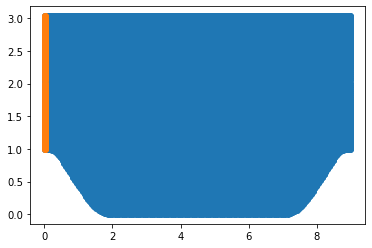

In [26]:
# find inlet cell zone. not necessary for periodic hills as inflow is periodic
cells_res = cellCenters.reshape(ny,nx,3)
cell_slice = cells_res[:,0]
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1])
ax.scatter(cell_slice[:,0], cell_slice[:,1])

In [27]:
# take values from cells closest to inflow boundary as boundary field
# this works as grid is structured
# not necessary for periodic hills as b should be 0 at top and bottom wall

# b_boundary = b_pred_filt.reshape(ny,nx,3,3)[:,0]
# rs_boundary = th.ones(nx,1,1) * th.tensor([[1e-10, 1e-10, 0], [1e-10, 1e-10, 0], [0, 0, 1e-1]]).unsqueeze(0)
# k_boundary = 0.5* (rs_boundary[:,0,0] + rs_boundary[:,1,1] + rs_boundary[:,2,2])
# b_boundary = anisotropy(rs_boundary, k_boundary)
# # b = rs_boundary - 2/3 * k_boundary.unsqueeze(1).unsqueeze(1)*th.eye
# b_boundary = enforce_realizability(b_boundary)
# b_boundary.shape

In [32]:
# # boundary list from periodic hills
b_list = [('topWall', 'fixedValue_uniform'),
          ('bottomWall', 'fixedValue_uniform'),
          ('inlet_half0', 'cyclic'),
          ('inlet_half1', 'cyclic'),
          ('outlet_half0', 'cyclic'),
          ('outlet_half1', 'cyclic'),
          ('sideRight_half0', 'empty'),
          ('sideRight_half1', 'empty'),
          ('sideLeft_half0', 'empty'),
          ('sideLeft_half1', 'empty')]

rans_time = '30000'

In [33]:
dd_case_path = pred_path

In [34]:
writesymmtensor(b_real_filt, os.sep.join([dd_case_path, rans_time, 'b_ml']), b_list)
# writesymmtensor(b_dns, os.sep.join([dd_case_path, rans_time, 'b_ml']), b_list)

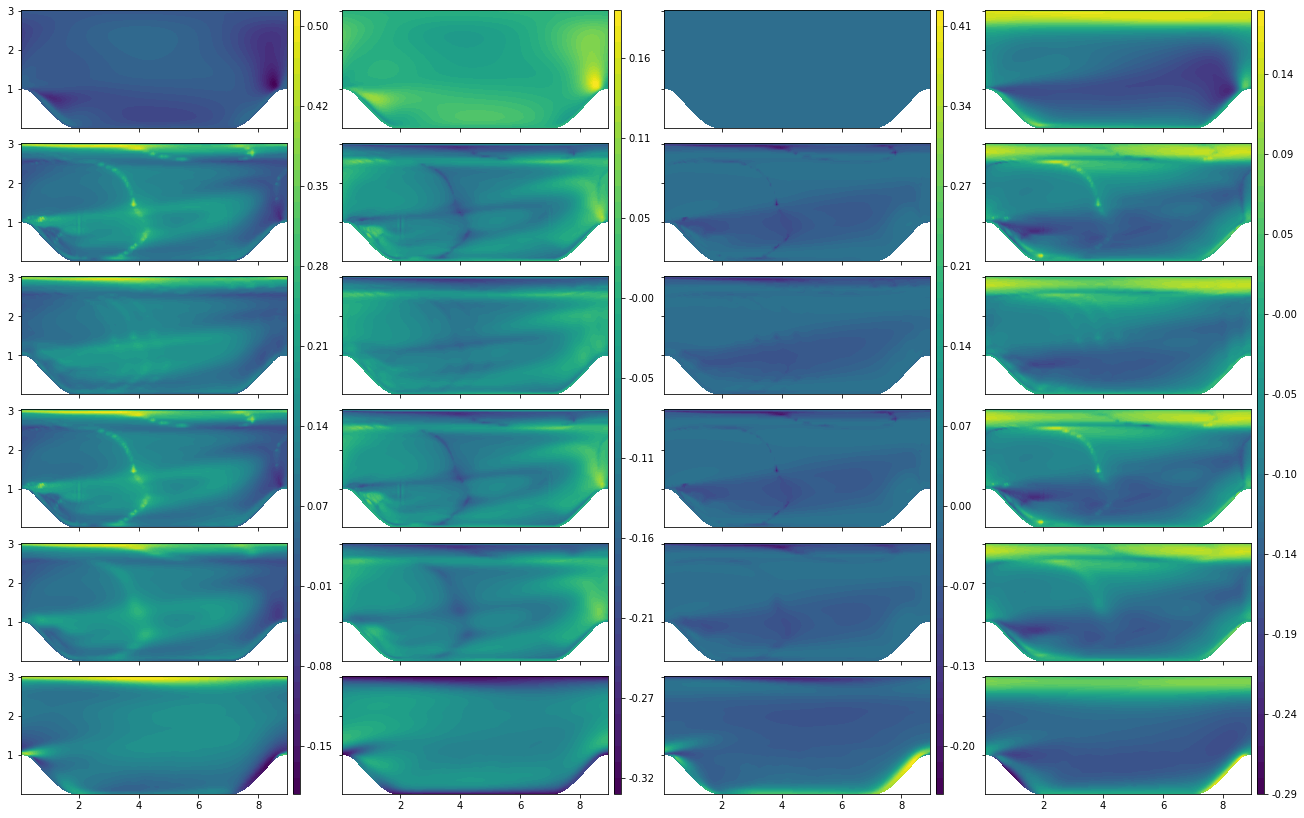

In [31]:
# nx, ny = 140, 100
b_pred_reshaped = b_pred.reshape(nx,ny,3,3).permute(2,3,0,1).detach().numpy()
b_pred_filt = th.from_numpy(filterField(b_pred_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)

# define refinement level of interpolation grid and how much of boundary should be but off
ref = 15
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(cellCenters[:,0].numpy()), np.max(cellCenters[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min an max of y coordinate
y_min, y_max = np.min(cellCenters[:,1].numpy()), np.max(cellCenters[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
grid_y_shifted = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y
grid_y = grid_y_shifted

# interpolate b tensor
grid_b_rans = griddata(cellCenters[:,0:2], b_rans.numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)
grid_b_pred = griddata(cellCenters[:,0:2], b_pred.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_pred_filt = griddata(cellCenters[:,0:2], b_pred_filt.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real = griddata(cellCenters[:,0:2], b_real.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real_filt = griddata(cellCenters[:,0:2], b_real_filt.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_dns = griddata(cellCenters[:,0:2], b_dns.numpy(), (grid_x, grid_y), method = 'linear')

# get min an max of (b_pred, b_test) for colormap
# tmp = th.cat((b_rans[:,idx[0],idx[1]], b_pred[:,idx[0],idx[1]], b_dns[:,idx[0],idx[1]])).detach().numpy()
# tmp = th.cat((grid_b_rans, grid_b_real, grid_b_dns)).detach().numpy()
tmp = np.vstack((grid_b_rans, grid_b_real, grid_b_dns))
b_min = np.min(tmp, axis=(0,1))
b_max = np.max(tmp, axis=(0,1))

components = [[0,0], [1,1], [2,2], [0,1]]
ncols = len(components)
nrows = 6
s = 1.5

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain


for i, cmp in enumerate(components):
    
    levels = np.linspace(b_min[cmp[0], cmp[1]], b_max[cmp[0], cmp[1]], 50)

    b_rans_plot = ax[0,i].contourf(grid_x, grid_y_shifted, grid_b_rans[:,:,cmp[0],cmp[1]], levels = levels)
    b_pred_plot = ax[1,i].contourf(grid_x, grid_y_shifted, grid_b_pred[:,:,cmp[0],cmp[1]], levels = levels)
    b_pred_filt_plot = ax[2,i].contourf(grid_x, grid_y_shifted, grid_b_pred_filt[:,:,cmp[0],cmp[1]], levels = levels)
    b_real_plot = ax[3,i].contourf(grid_x, grid_y_shifted, grid_b_real[:,:,cmp[0],cmp[1]], levels = levels)
    b_real_filt_plot = ax[4,i].contourf(grid_x, grid_y_shifted, grid_b_real_filt[:,:,cmp[0],cmp[1]], levels = levels)
    b_dns_plot = ax[5,i].contourf(grid_x, grid_y_shifted, grid_b_dns[:,:,cmp[0],cmp[1]], levels = levels)

    fig.colorbar(b_pred_filt_plot, ax=ax[:,i].flat, aspect=7.5*ncols*nrows, format='%.2f', pad=0.0)

# x_off = -1.5
# y_off = 1.5

# ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left', va='center')
# ax[1].text(x_off,y_off, r'TBNN' '\n' r'unfiltered', fontsize='medium', ha='left')
# ax[2].text(x_off,y_off, r'TBNN' '\n' r'filtered', fontsize='medium', ha='left')
# ax[3].text(x_off,y_off, r'TBNN' '\n' r'realizable', fontsize='medium', ha='left', va='center')
# ax[4].text(x_off,y_off, r'TBNN' '\n' r'realizable' '\n' 'filtered', fontsize='medium', ha='left', va='center')
# ax[5].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')


# save fig
# fig_name = os.sep.join([fig_path, 'griddata.pdf'])
# plt.savefig(fig_name, format='pdf')

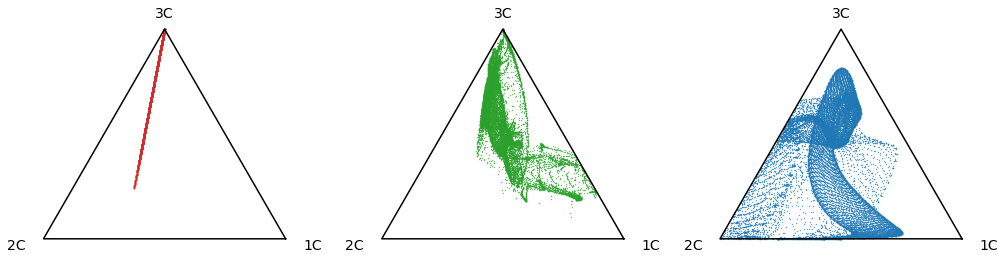

In [20]:
fig, ax = plt.subplots(1,3, figsize=(14,3.5), sharey=True, constrained_layout=True)

ax[0].axis('equal')
ax[0].axis('off')
ax[1].axis('equal')
ax[1].axis('off')
ax[2].axis('equal')
ax[2].axis('off')

barm_rans = BarMap()
# barm_rans.load_from_variable(b_rans[index], cellCenters[index][:,0:2])
barm_rans.load_from_variable(b_rans, cellCenters[:,0:2])
barm_rans.calculate_barycentric_coordinates()
barm_rans.plot_triangle(ax[0])
barm_rans.plot_data_points(ax[0], color=sns.color_palette()[3], s=0.1)

barm_pred = BarMap()
# barm_pred.load_from_variable(b_pred[index].detach().numpy(), cellCenters[index][:,0:2])
barm_pred.load_from_variable(b_pred.detach().numpy(), cellCenters[:,0:2])
barm_pred.calculate_barycentric_coordinates()
barm_pred.plot_triangle(ax[1])
barm_pred.plot_data_points(ax[1], color=sns.color_palette()[2], s=0.1)

barm_dns = BarMap()
# barm_dns.load_from_path(path_dns)
barm_dns.load_from_variable(b_dns, cellCenters[:,0:2])
barm_dns.calculate_barycentric_coordinates()
barm_dns.plot_triangle(ax[2])
barm_dns.plot_data_points(ax[2], color=sns.color_palette()[0], s=0.1)

for axs in ax.flat:
        axs.text(1.15, 0.0, '1C', fontsize=14,
            horizontalalignment='right', verticalalignment='top')
        axs.text(-0.15, 0.0, '2C', fontsize=14,
            horizontalalignment='left', verticalalignment='top')
        axs.text(0.50, 0.9, '3C', fontsize=14,
            horizontalalignment='center', verticalalignment='bottom')
        
# save figure
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/abstract'
fig_name = time() + 'barmap_conv.svg'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='svg')

(-0.05, 1.05, -0.04330127018922193, 0.9093266739736605)

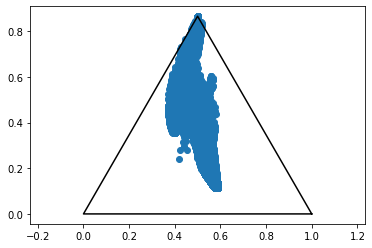

In [18]:
fig, ax = plt.subplots()
barm_pred.plot_triangle(ax)
barm_pred.plot_data_points(ax)
ax.axis('equal')
# plt.xlim([0,1])
# plt.ylim([0,1])

In [19]:
# b_raw = th.rand(5,3,3) - 0.5
# b1 = 0.5 * (b_raw + b_raw.transpose(1,2))
# b_trace = b1[:,0,0] + b1[:,1,1] + b1[:,2,2]
# tensor = b1 - 1./3. * th.eye(3).unsqueeze(0) * b_trace.unsqueeze(1).unsqueeze(2)
# print(tensor, tensor.shape)

In [20]:
# b_test = b.clone()
# b_test_real = enforce_realizability(b_test)

In [21]:
tensor = b_pred.clone()
tensor_2 = tensor.clone()

In [22]:
print(tensor[:2])

tensor([[[ 4.4872e-05, -5.9016e-04,  0.0000e+00],
         [-5.9016e-04, -4.9780e-05,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  4.9074e-06]],

        [[ 3.6169e-05, -6.1071e-04, -2.6034e-25],
         [-6.1071e-04, -4.0122e-05,  2.1461e-27],
         [-2.6034e-25,  2.1461e-27,  3.9537e-06]]], dtype=torch.float64)


In [23]:
eigval, eigvec = th.symeig(tensor, eigenvectors=True)
print(eigval)
eigval_orig = eigval.clone()

tensor([[-5.9451e-04,  4.9074e-06,  5.8960e-04],
        [-6.1387e-04,  3.9537e-06,  6.0992e-04],
        [-5.0147e-04,  3.6625e-06,  4.9781e-04],
        ...,
        [-1.0754e-03,  1.3792e-05,  1.0616e-03],
        [-1.0778e-03,  1.3853e-05,  1.0639e-03],
        [-1.0791e-03,  1.3889e-05,  1.0653e-03]], dtype=torch.float64)


In [24]:
# tensor = enforce_realizability(tensor)
eigval, eigvec = th.symeig(tensor, eigenvectors=True)
labels = (eigval[:,2] < (3*th.abs(eigval[:,1]) - eigval[:,1])*.5).unsqueeze(1)
eigval *= labels*((3. * th.abs(eigval[:,1]) - eigval[:,1]) / (2.*eigval[:,2])).unsqueeze(1) + ~labels
print('Violation of condition 1:      {}'.format(th.max(labels)))

small = 0.005
labels = (eigval[:,2] > 1./3. - eigval[:,1]).unsqueeze(1)
eigval *= labels*((1./3. - eigval[:,1]) / (eigval[:,2]) - small).unsqueeze(1) + ~labels
print('Violation of condition 2:      {}'.format(th.max(labels)))
print('Index of violation:\n', th.where(labels == True)[0][0:5])
print('Eigenvalues of those tensors:\n', th.symeig(tensor[th.where(labels == True)[0]])[0][0:5])
tensor = eigvec.matmul(th.diag_embed(eigval).matmul(eigvec.transpose(1,2)))

tensor_2 = enforce_realizability(tensor_2, small)
th.max(tensor - tensor_2)

Violation of condition 1:      False
Violation of condition 2:      False
Index of violation:
 tensor([], dtype=torch.int64)
Eigenvalues of those tensors:
 tensor([], size=(0, 3), dtype=torch.float64)
Violation of condition 1: False
Violation of condition 2: False


tensor(0., dtype=torch.float64)

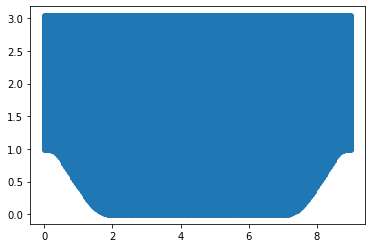

In [25]:
cellCenters[th.where(labels == True)[0]]#
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1])
ax.scatter(cellCenters[th.where(labels == True)[0],0], cellCenters[th.where(labels == True)[0],1])

In [26]:
# print(b_pred[th.where(labels == True)[0]])

<AxesSubplot:>

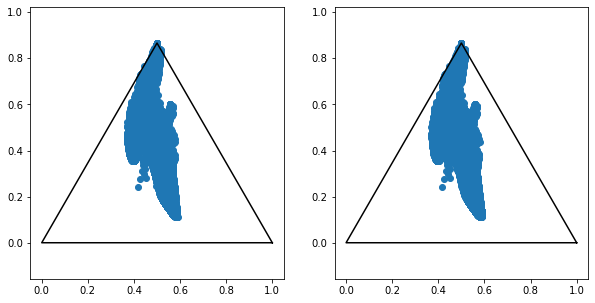

In [27]:
barm_corrected = BarMap()
barm_corrected.load_from_variable(tensor.detach(), cellCenters[:,0:2])
barm_corrected.calculate_barycentric_coordinates()

barm_corrected_2 = BarMap()
barm_corrected_2.load_from_variable(tensor_2.detach(), cellCenters[:,0:2])
barm_corrected_2.calculate_barycentric_coordinates()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
ax1.axis('equal')
ax2.axis('equal')
barm_corrected.plot_triangle(ax1)
barm_corrected.plot_data_points(ax1)
barm_corrected_2.plot_triangle(ax2)
barm_corrected_2.plot_data_points(ax2)

In [28]:
def barycentric_coefficients(eigval):
    coords = th.empty_like(eigval)
    coords[:,0] = eigval[:,2] - eigval[:,1]
    coords[:,1] = 2.*(eigval[:,1] - eigval[:,0])
    coords[:,2] = 3.*eigval[:,0]+1.
    return coords

In [29]:
n = r_hat.shape[0]
r_hat_clear = r_hat.clone()
r_hat_clear[:,0,0] = th.zeros(n)
r_hat_clear[:,0,2] = th.zeros(n)
r_hat_clear[:,1,1] = th.zeros(n)
r_hat_clear[:,1,2] = th.zeros(n)
r_hat_clear[:,2,0] = th.zeros(n)
r_hat_clear[:,2,1] = th.zeros(n)
r_hat_clear[:,2,2] = th.zeros(n)

s_hat_clear = s_hat.clone()
s_hat_clear[:,0,2] = th.zeros(n)
s_hat_clear[:,1,2] = th.zeros(n)
s_hat_clear[:,2,0] = th.zeros(n)
s_hat_clear[:,2,1] = th.zeros(n)
s_hat_clear[:,2,2] = th.zeros(n)

inv_clear = get_invariants(s_hat_clear, r_hat_clear)

In [30]:
th.max(s_hat[:,0,0] - s_hat[:,1,1])

tensor(4.3021, dtype=torch.float64)

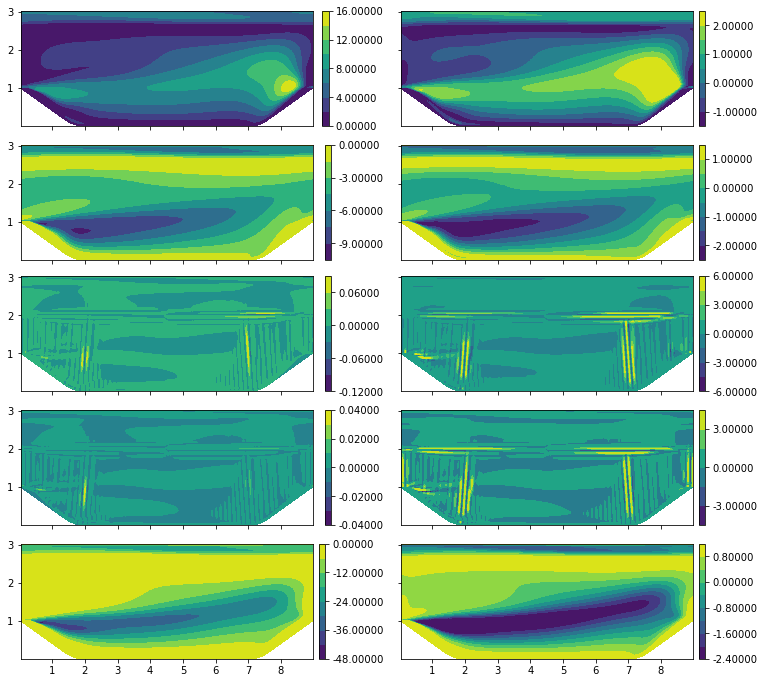

In [31]:
fig_path = '/home/leonriccius/Desktop'
nrows = 5
ncols = 2
s = 1.5

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

for i in range(5):
    unscaled = ax[i,0].tricontourf(cellCenters[:,0], cellCenters[:,1], inv[:,i])
    mean_std = ax[i,1].tricontourf(cellCenters[:,0], cellCenters[:,1], inv_mean_std[:,i])
    
    cbar_unscaled = fig.colorbar(unscaled, ax=ax[i,0], format='%.5f', pad=0.0)
    cbar_mean_std = fig.colorbar(mean_std, ax=ax[i,1], format='%.5f', pad=0.0)
    
    cbar_unscaled.ax.locator_params(nbins=5)
    cbar_mean_std.ax.locator_params(nbins=5)
    
# save figure
fig_name = time() + '_phill_scaling_options'
# plt.savefig(os.sep.join([fig_path, fig_name + '.pdf']), format='pdf')
# tikz.save(os.sep.join([fig_path, fig_name + '.pgf']))
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

In [32]:
# nrows = 6
# ncols = 1
# s = 1.5

# idx = [2,2]

# # nx, ny = 140, 100
# b_pred_reshaped = b_pred.reshape(nx,ny,3,3).permute(2,3,0,1).detach().numpy()
# b_pred_filt = th.from_numpy(filterField(b_pred_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)

# ref = 15
# gamma = 0.995
# x_min, x_max = np.min(cellCenters[:,0].numpy()), np.max(cellCenters[:,0].numpy())
# x_mean = 0.5*(x_max - x_min)
# x_min_neu = x_mean - gamma*(x_mean - x_min)
# x_max_neu = x_mean - gamma*(x_mean - x_max)

# y_min, y_max = np.min(cellCenters[:,1].numpy()), np.max(cellCenters[:,1].numpy())
# y_mean = 0.5*(y_max - y_min)
# y_min_neu = y_mean - gamma*(y_mean - y_min)
# y_max_neu = y_mean - gamma*(y_mean - y_max)

# print(x_min, x_max)
# print(x_min_neu, x_max_neu)
# x_min, x_max = x_min_neu, x_max_neu
# y_min, y_max = y_min_neu, y_max_neu
# np_x = int(ref*(x_max - x_min))
# np_y = int(ref*(y_max - y_min))

# grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
# grid_y_shifted = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y
# grid_y = grid_y_shifted

# grid_b_rans = griddata(cellCenters[:,0:2], b_rans.numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method = 'linear') #, fill_value=0.)
# grid_b_pred = griddata(cellCenters[:,0:2], b_pred.numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method = 'linear')
# grid_b_pred_filt = griddata(cellCenters[:,0:2], b_pred_filt.numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method = 'linear')
# grid_b_real = griddata(cellCenters[:,0:2], b_real.numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method = 'linear')
# grid_b_real_filt = griddata(cellCenters[:,0:2], b_real_filt.numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method = 'linear')
# grid_b_dns = griddata(cellCenters[:,0:2], b_dns.numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method = 'linear')

# # get min an max of (b_pred, b_test) for colormap
# # tmp = th.cat((b_rans[:,idx[0],idx[1]], b_pred[:,idx[0],idx[1]], b_dns[:,idx[0],idx[1]])).detach().numpy()
# # tmp = th.cat((grid_b_rans, grid_b_real, grid_b_dns)).detach().numpy()
# tmp = np.vstack((grid_b_rans, grid_b_real, grid_b_dns))
# b_min = np.min(tmp)
# b_max = np.max(tmp)
# levels = np.linspace(b_min, b_max, 50)

# # # create figure
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
#                        constrained_layout=True)

# b_rans_plot = ax[0].contourf(grid_x, grid_y_shifted, grid_b_rans, levels = levels)
# b_pred_plot = ax[1].contourf(grid_x, grid_y_shifted, grid_b_pred, levels = levels)
# b_pred_filt_plot = ax[2].contourf(grid_x, grid_y_shifted, grid_b_pred_filt, levels = levels)
# b_real_plot = ax[3].contourf(grid_x, grid_y_shifted, grid_b_real, levels = levels)
# b_real_filt_plot = ax[4].contourf(grid_x, grid_y_shifted, grid_b_real_filt, levels = levels)
# b_dns_plot = ax[5].contourf(grid_x, grid_y_shifted, grid_b_dns, levels = levels)

# fig.colorbar(b_pred_filt_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)

# x_off = -1.5
# y_off = 1.5

# ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left', va='center')
# ax[1].text(x_off,y_off, r'TBNN' '\n' r'unfiltered', fontsize='medium', ha='left')
# ax[2].text(x_off,y_off, r'TBNN' '\n' r'filtered', fontsize='medium', ha='left')
# ax[3].text(x_off,y_off, r'TBNN' '\n' r'realizable', fontsize='medium', ha='left', va='center')
# ax[4].text(x_off,y_off, r'TBNN' '\n' r'realizable' '\n' 'filtered', fontsize='medium', ha='left', va='center')
# ax[5].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')


# # save fig
# # fig_name = os.sep.join([fig_path, 'griddata.pdf'])
# # plt.savefig(fig_name, format='pdf')